##### Import the libraries

In [1]:
import os
import json
import torch
import torch.optim as optim
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
import torchvision
import torchvision.transforms as transforms
from torchvision.ops import box_iou
from torchvision.ops import nms
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.metrics import precision_recall_fscore_support
import rich
from PIL import Image, ImageDraw
from segmentation_models_pytorch import Unet

##### Draw segmentations on the images to create masks

In [ ]:
'''
# Define the directories
image_directory = os.path.join("ZJU_dataset_2", "images")
input_directory = os.path.join("ZJU_dataset_2", "annotation")
output_directory = os.path.join("ZJU_dataset_2", "masks")

# Create the masks directory if it doesn't exist
os.makedirs(output_directory, exist_ok=True)

# Iterate over each JSON file in the input directory
for json_file in os.listdir(input_directory):
    if not json_file.endswith('.json'):
        continue

    json_path = os.path.join(input_directory, json_file)

    # Load the JSON file
    with open(json_path, 'r') as f:
        data = json.load(f)

    # Get the image details from the JSON file
    image_filename = data['imagePath']
    image_path = os.path.join(image_directory, image_filename)

    # Check if the image file exists
    if not os.path.exists(image_path):
        print(f"Image {image_path} does not exist.")
        continue

    # Load the image to get its dimensions
    image = Image.open(image_path)
    width, height = image.size

    # Create a blank mask
    mask = Image.new('L', (width, height), 0)
    draw = ImageDraw.Draw(mask)

    # Draw the polygons on the mask
    for shape in data['shapes']:
        if shape['label'] == 'window':  # Check if the label is 'window'
            polygon = [(x, y) for x, y in shape['points']]
            draw.polygon(polygon, outline=50, fill=255)

    # Save the mask
    mask_filename = f"mask_{image_filename.replace('.jpg', '.png')}"
    mask_path = os.path.join(output_directory, mask_filename)
    mask.save(mask_path)
    # print(f"Saved mask for {image_filename} to {mask_path}")
    '''

##### Transform to tensor

In [2]:
class FacadeDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = [file for file in os.listdir(image_dir) if file.endswith('.jpg')]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.image_dir, img_name)
        mask_name = f"mask_{os.path.splitext(img_name)[0]}.png"
        mask_path = os.path.join(self.mask_dir, mask_name)
        
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask


# Define transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Directories for training
train_image_dir = os.path.join("ZJU_dataset_2", "images")
train_masks_dir = os.path.join("ZJU_dataset_2", "masks")

# Create dataset
dataset = FacadeDataset(train_image_dir, train_masks_dir, transform=transform)

# print("Dataset :", dataset[0])

print("Dataset length:", len(dataset))

Dataset length: 216


##### Split the dataset

In [3]:
# Define the proportions for train, validation, and test
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

# Load the full dataset (assuming train_annotations includes all data at this stage)
full_dataset = FacadeDataset(train_image_dir, train_masks_dir, transform=transform)

# Calculate lengths of each split
train_size = int(train_ratio * len(full_dataset))
val_size = int(val_ratio * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

# Split the dataset into train, validation, and test sets
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

print("Train dataset size:", len(train_dataset))
print("Validation dataset size:", len(val_dataset))
print("Test dataset size:", len(test_dataset))

Train dataset size: 151
Validation dataset size: 43
Test dataset size: 22


##### Prepare Data Loaders

In [4]:
# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

print("Train dataset:", len(train_dataset))
print("Validation dataset:", len(val_dataset))
print("Test dataset:", len(test_dataset))

Train dataset: 151
Validation dataset: 43
Test dataset: 22


##### Checking the input data

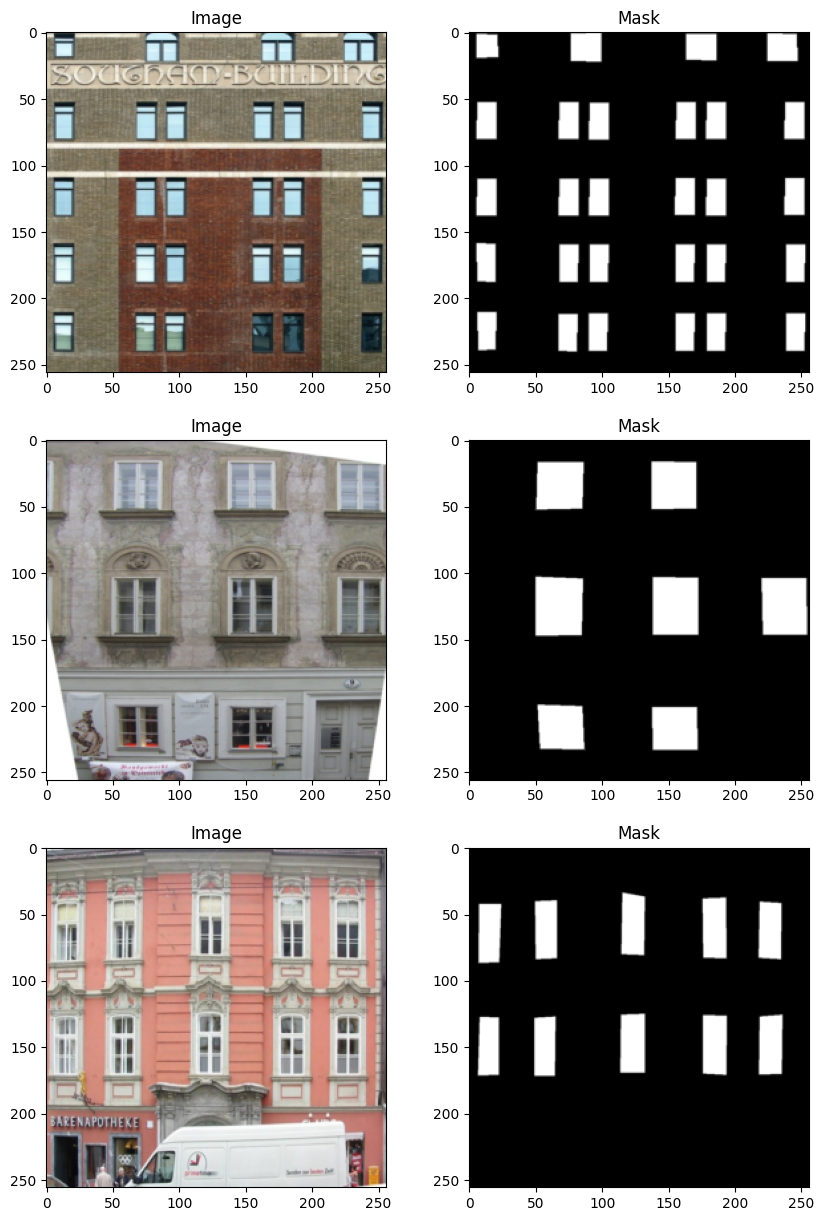

In [5]:
# Visualize some samples
def visualize_samples(dataset, num_samples=3):
    fig, axs = plt.subplots(num_samples, 2, figsize=(10, num_samples * 5))
    for i in range(num_samples):
        image, mask = dataset[i]
        axs[i, 0].imshow(image.permute(1, 2, 0))  # assuming image is in (C, H, W) format and needs permute to (H, W, C)
        axs[i, 0].set_title('Image')
        axs[i, 1].imshow(mask.squeeze(), cmap='gray')  # squeeze to remove single channel dimension
        axs[i, 1].set_title('Mask')
    plt.show()

visualize_samples(train_dataset)


##### Define The Model

In [6]:
# Initialize U-Net model
model = Unet(encoder_name="resnet34",        # Choose encoder architecture
             encoder_weights="imagenet",    # Use pre-trained weights
             in_channels=3,                 # Input channels (RGB)
             classes=1)                     # Output channels (binary segmentation)

##### Check if Cuda is avaliable and what GPU does it use

In [7]:
# Check if CUDA is available and print the device being used
if torch.cuda.is_available():
    print("CUDA is available. Using GPU:", torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    print("CUDA is not available. Using CPU.")

CUDA is available. Using GPU: NVIDIA GeForce GTX 1660 Ti


In [10]:
def find_best_hyperparameters_segmentation(
    model, 
    train_loader, 
    val_loader, 
    param_grid, 
    device='cuda', 
    num_epochs=5
):
    """
    Find the best hyperparameters for the segmentation model using grid search.
    
    Parameters:
        model: The model to be trained and evaluated.
        train_loader: DataLoader for the training set.
        val_loader: DataLoader for the validation set.
        param_grid: Dictionary of hyperparameters to search. Example:
                    {
                        'lr': [0.0001, 0.001],
                        'weight_decay': [0.0001, 0.001]
                    }
        device: Device to use ('cuda' or 'cpu').
        num_epochs: Number of epochs for each hyperparameter combination.
    
    Returns:
        A dictionary with the best hyperparameters and their corresponding metrics.
    """
    from itertools import product
    import torch.nn as nn
    import torch.optim as optim

    criterion = nn.BCEWithLogitsLoss()  # Binary cross-entropy loss with logits
    best_params = None
    best_metrics = None

    # Generate all combinations of hyperparameters
    keys, values = zip(*param_grid.items())
    param_combinations = [dict(zip(keys, v)) for v in product(*values)]

    for params in param_combinations:
        print(f"Testing hyperparameters: {params}")

        # Update optimizer
        optimizer = optim.Adam(
            model.parameters(), 
            lr=params['lr'], 
            weight_decay=params.get('weight_decay', 0.0)
        )
        
        # Training loop
        model = model.to(device)
        for epoch in range(num_epochs):
            model.train()
            for images, masks in train_loader:
                images, masks = images.to(device), masks.to(device)

                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, masks)
                loss.backward()
                optimizer.step()

        # Validation loop
        model.eval()
        with torch.no_grad():
            total_iou, total_precision, total_recall, total_f1 = 0, 0, 0, 0
            num_batches = 0

            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                preds = torch.sigmoid(outputs) > 0.5  # Threshold predictions at 0.5

                # Flatten predictions and masks for metric calculation
                preds_flat = preds.view(-1)
                masks_flat = masks.view(-1).bool()

                # IoU
                intersection = (preds_flat & masks_flat).sum().item()
                union = (preds_flat | masks_flat).sum().item()
                iou = intersection / union if union > 0 else 0
                total_iou += iou

                # Precision, Recall, F1-Score
                tp = (preds_flat & masks_flat).sum().item()
                fp = (preds_flat & ~masks_flat).sum().item()
                fn = (~preds_flat & masks_flat).sum().item()

                precision = tp / (tp + fp) if (tp + fp) > 0 else 0
                recall = tp / (tp + fn) if (tp + fn) > 0 else 0
                f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

                total_precision += precision
                total_recall += recall
                total_f1 += f1
                num_batches += 1

            # Mean metrics over validation set
            mean_iou = total_iou / num_batches
            mean_precision = total_precision / num_batches
            mean_recall = total_recall / num_batches
            mean_f1 = total_f1 / num_batches

        metrics = {
            'mean_iou': mean_iou,
            'precision': mean_precision,
            'recall': mean_recall,
            'f1': mean_f1
        }

        print(f"Metrics for {params}: {metrics}")

        if best_metrics is None or metrics['f1'] > best_metrics['f1']:
            best_params = params
            best_metrics = metrics

    print(f"Best hyperparameters: {best_params}")
    print(f"Best metrics: {best_metrics}")
    return {'best_params': best_params, 'best_metrics': best_metrics}


In [11]:
param_grid = {
    'lr': [0.0001, 0.001],
    'weight_decay': [0.0001, 0.001]
}


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
best_hyperparams = find_best_hyperparameters_segmentation(model, train_loader, val_loader, param_grid, device=device)


Testing hyperparameters: {'lr': 0.0001, 'weight_decay': 0.0001}
Metrics for {'lr': 0.0001, 'weight_decay': 0.0001}: {'mean_iou': 0.6281051949986088, 'precision': 0.7800539035780664, 'recall': 0.773556659589206, 'f1': 0.7641883193022224}
Testing hyperparameters: {'lr': 0.0001, 'weight_decay': 0.001}
Metrics for {'lr': 0.0001, 'weight_decay': 0.001}: {'mean_iou': 0.6556524910460944, 'precision': 0.8186389642441902, 'recall': 0.7789821708566105, 'f1': 0.7867930764709695}
Testing hyperparameters: {'lr': 0.001, 'weight_decay': 0.0001}
Metrics for {'lr': 0.001, 'weight_decay': 0.0001}: {'mean_iou': 0.5259596784482737, 'precision': 0.8800656699623274, 'recall': 0.5700312940776592, 'f1': 0.6806671591542386}
Testing hyperparameters: {'lr': 0.001, 'weight_decay': 0.001}
Metrics for {'lr': 0.001, 'weight_decay': 0.001}: {'mean_iou': 0.29893565508364206, 'precision': 0.702015485060423, 'recall': 0.3441012532681691, 'f1': 0.4219609802585966}
Best hyperparameters: {'lr': 0.0001, 'weight_decay': 0.00

##### Train The Model

In [9]:
# Move the model to the GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)  # Ensure data is on the same device as model
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")


Epoch 1/5, Loss: 0.5947423581230012
Epoch 2/5, Loss: 0.34355516182748896
Epoch 3/5, Loss: 0.2449367585542955
Epoch 4/5, Loss: 0.19480136644683385
Epoch 5/5, Loss: 0.16383417656547145


##### train with validation

In [12]:
# Move the model to the GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()  # Binary cross-entropy loss
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)  # Ensure data is on the same device as model

        optimizer.zero_grad()
        outputs = model(images)  # Predictions from the U-Net
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")
    
    # Evaluation on validation set
    model.eval()
    with torch.no_grad():
        total_iou, total_precision, total_recall, total_f1 = 0, 0, 0, 0
        num_batches = 0

        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            preds = torch.sigmoid(outputs) > 0.5  # Threshold predictions at 0.5

            # Flatten predictions and masks for metric calculation
            preds_flat = preds.view(-1)
            masks_flat = masks.view(-1).bool()

            # IoU
            intersection = (preds_flat & masks_flat).sum().item()
            union = (preds_flat | masks_flat).sum().item()
            iou = intersection / union if union > 0 else 0
            total_iou += iou

            # Precision, Recall, F1-Score
            tp = (preds_flat & masks_flat).sum().item()
            fp = (preds_flat & ~masks_flat).sum().item()
            fn = (~preds_flat & masks_flat).sum().item()

            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

            total_precision += precision
            total_recall += recall
            total_f1 += f1
            num_batches += 1

        # Mean metrics over validation set
        mean_iou = total_iou / num_batches
        mean_precision = total_precision / num_batches
        mean_recall = total_recall / num_batches
        mean_f1 = total_f1 / num_batches

        print(f"Validation Metrics - Epoch {epoch+1}/{num_epochs}")
        print(f"  Mean IoU: {mean_iou:.4f}")
        print(f"  Precision: {mean_precision:.4f}")
        print(f"  Recall: {mean_recall:.4f}")
        print(f"  F1 Score: {mean_f1:.4f}")

print("Training complete!")


Epoch 1/5, Loss: 0.1669
preds tensor([[[[False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          ...,
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False]]],


        [[[False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          ...,
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False]]]], device='cuda:0')
masks tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
       

##### Visualzing the results (predictions) on the test subset

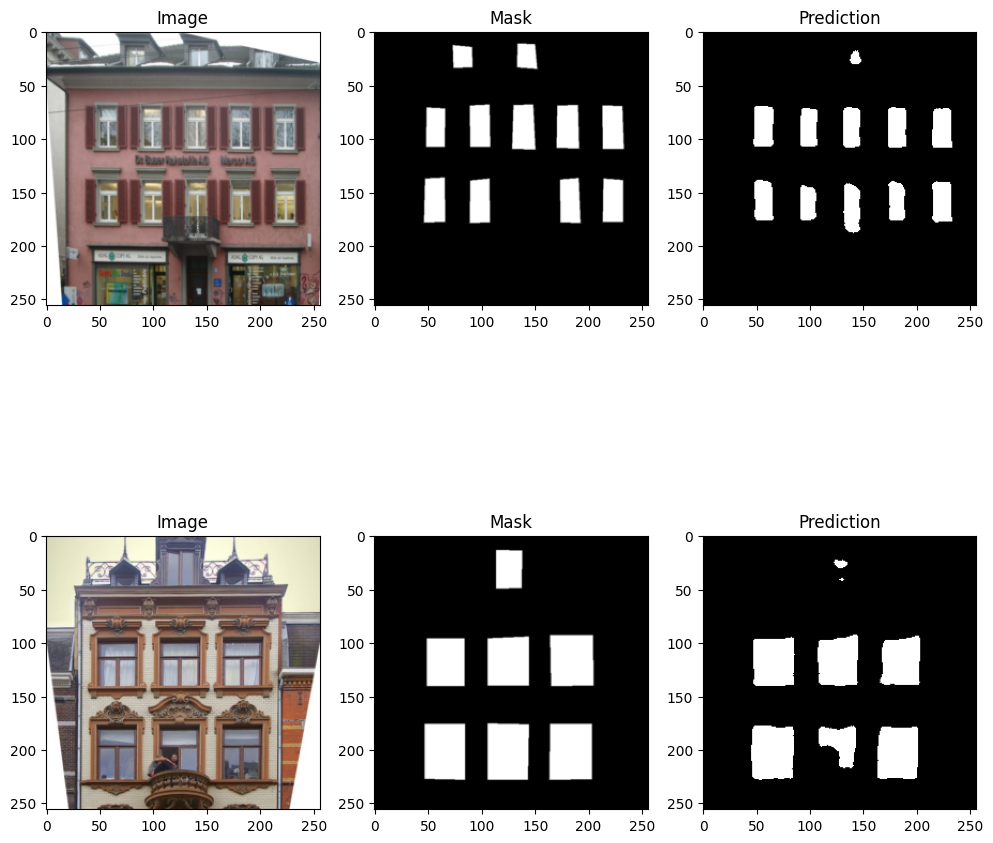

In [13]:
# Get a batch of validation data
images, masks = next(iter(test_loader))
images, masks = images.to(device), masks.to(device)

model.eval()
with torch.no_grad():
    outputs = model(images)
    outputs = torch.sigmoid(outputs)  # Apply sigmoid to get probabilities
    preds = outputs > 0.5  # Threshold to get binary predictions

# Plot some sample images and their predictions
fig, axs = plt.subplots(2, 3, figsize=(12, 12))
for i in range(2):
    axs[i, 0].imshow(images[i].cpu().permute(1, 2, 0))  # Assuming image is in (C, H, W) format
    axs[i, 0].set_title('Image')
    axs[i, 1].imshow(masks[i].cpu().squeeze(), cmap='gray')  # Squeeze to remove single channel dimension
    axs[i, 1].set_title('Mask')
    axs[i, 2].imshow(preds[i].cpu().squeeze(), cmap='gray')  # Squeeze to remove single channel dimension
    axs[i, 2].set_title('Prediction')

plt.show()

##### save and load the model

In [14]:
# Define the path to save the model
save_path = "unet_checkpoint.pth"

# Save the model and optimizer state dictionaries
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': epoch + 1,  # Save the last completed epoch
}, save_path)

print(f"Model saved to {save_path}")


Model saved to unet_checkpoint.pth
